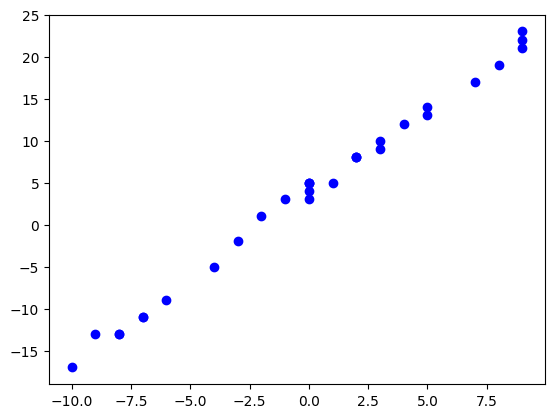

In [113]:
import numpy as np
import random
from matplotlib import pyplot as plt

w = 2
b = 3
xlim = [-10, 10]
x_train = np.random.randint(low=xlim[0], high=xlim[1], size=30)

y_train = [w * x + b + random.randint(0,2) for x in x_train]

plt.plot(x_train, y_train, 'bo')

In [114]:
import torch
from torch import nn

class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1))
    self.bias = nn.Parameter(torch.randn(1))

  def forward(self, input):
    return (input * self.weight) + self.bias

1. 必须继承 nn.Module 类
2. 必须实现 __init__ 
3. 必须实现 forward 方法

nn.Module 模块 

Torchvison 中的那些模型，也都是通过继承 nn.Module 模块来构建网络模型的

模块本身是 callable 的，当调用它的时候，就是执行 forward 函数，也就是前向传播。

```python
model = LinearModel()
x = torch.tensor(3)
y = model(x)
print(y)  # 输出 tensor(7)
```

必须调用父类的构造方法才可以，也就是这行代码： super(LinearModel, self).__init__()

因为在 nn.Module 的 __init__() 中，会初始化一些有序的字典与集合。这些集合用来存储一些模型训练过程的中间变量，如果不初始化 nn.Module 中的这些参数的话，模型就无法正常工作。

模型定义好之后，还没有被训练。要想训练我们的模型，就需要用到损失函数与优化方法。

这里选择的是 MSE 损失与 SGD 优化方法。

![image12.png](mdfiles/image12.png)

In [115]:
model = LinearModel()
# 定义优化器
# SGD 随机梯度下降
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)

y_train = torch.tensor(y_train, dtype=torch.float32)
for _ in range(1000):
    input = torch.from_numpy(x_train)
    output = model(input)
    loss = nn.MSELoss()(output, y_train)
    model.zero_grad()
    # 如何backward的？
    # PyTorch 就会从这张计算图的 输出节点（loss） 开始，沿着反方向自动求导
    # 梯度 存入每个参数张量的 .grad 属性
    loss.backward()
    # 如何把这个传递给的optimizer的呢？
    # optimizer.step()：PyTorch 会自动遍历这些参数，并按照优化算法更新它们的值
    optimizer.step()


for parameter in model.named_parameters():
  print(parameter)

('weight', Parameter containing:
tensor([2.0181], requires_grad=True))
('bias', Parameter containing:
tensor([3.2404], requires_grad=True))


继承一个 nn.Module 之后，可以定义自己的网络模型。Module 同样可以作为另外一个 Module 的一部分，被包含在网络中。比如，我们要设计下面这样的一个网络:

![image13.png](mdfiles/image13.png)

In [116]:
# class CustomModel(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
#     self.conv1_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')
#     self.conv_m_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
#     self.conv_m_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')
#     self.conv_n_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding='same')
#     self.conv_n_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=2, padding='same')

#   def forward(self, input):
#     x = self.conv1_1(input)
#     x = self.conv1_2(x)
#     x = self.conv_m_1(x)
#     x = self.conv_m_2(x)
#     x = self.conv_n_1(x)
#     x = self.conv_n_2(x)
#     return x


class CustomLayer(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=3, padding='same')
    self.conv1_2 = nn.Conv2d(in_channels=3, out_channels=output_channels, kernel_size=2, padding='same')
    
  def forward(self, input):
    x = self.conv1_1(input)
    x = self.conv1_2(x)
    return x
    

class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = CustomLayer(1,1)
    self.layerm = CustomLayer(1,1)
    self.layern = CustomLayer(1,1)
  
  def forward(self, input):
    x = self.layer1(input)
    x = self.layerm(x)
    x = self.layern(x)
    return x
  

  #残差块、Inception 块这样 多层结构的设计，都可以用这种方式来实现
  


## 模型保存和加载

### 只保存训练好的参数

第一种方式就是只保存训练好的参数。然后加载模型的时候，你需要通过代码加载网络结构，然后再将参数赋予网络。

```python
# 保存模型参数
torch.save(model.state_dict(), './linear_model.pth')
```
第一个参数是模型的 state_dict，而第二个参数要保存的位置。

加载模型参数的时候，需要先创建模型的实例，然后再加载参数。

```python

# 先定义网络结构
linear_model = LinearModel()
# 加载保存的参数
linear_model.load_state_dict(torch.load('./linear_model.pth'))
linear_model.eval()
for parameter in linear_model.named_parameters():
  print(parameter)
输出：
('weight', Parameter containing:
tensor([[2.0071]], requires_grad=True))
('bias', Parameter containing:
tensor([3.1690], requires_grad=True))
```


这里有个 model.eval() 需要你注意一下，因为有些层（例如，Dropout 与 BN）在训练时与评估时的状态是不一样的，当进入评估时要执行 model.eval()，模型才能进入评估状态。
这里说的评估不光光指代评估模型，也包括模型上线时候时的状态。

### 保存网络结构与参数

```python
# 保存整个模型
torch.save(model, './linear_model_with_arc.pth')
# 加载模型，不需要创建网络了 !!!!!!
linear_model_2 = torch.load('./linear_model_with_arc.pth')
linear_model_2.eval()
for parameter in linear_model_2.named_parameters():
  print(parameter)
# 输出：
('weight', Parameter containing:
tensor([[2.0071]], requires_grad=True))
('bias', Parameter containing:
tensor([3.1690], requires_grad=True))
```



## 使用 Torchvison 中的模型进行训练

Torchvision 提供了一些封装好的网络结构，我们可以直接拿过来使用。但是并没有细说如何使用它们在我们的数据集上进行训练。

我们就来看看如何使用这些网络结构，在我们自己的数据上训练我们自己的模型。


### 微调

最关键的一步就是之前讲的调整最后全连接层输出的数目，以适应我们自己的数据集。

那个时候说的是固定整个网络的参数，只训练最后的全连接层。今天我再给你介绍另外一种微调的方式，那就是修改全连接层之后，整个网络都重新开始训练

In [117]:
import torchvision.models as models
import os
os.environ['TORCH_HOME'] = './data'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(pretrained=True).to(device)
# alexnet = models.alexnet().to(device)



d:\software\miniconda\envs\rad-dino\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\miniconda\envs\rad-dino\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


第一种方式（固定整个网络的参数，只训练最后的全连接层），只需要在读取完预训练模型之后，将全连接层之前的参数全部锁死即可，也就是让他们无法训练，我们模型训练时，只训练全连接层就行了，其余一切都不变。代码如下所示：

In [118]:
alexnet.load_state_dict(torch.load('./data/hub/checkpoints/alexnet-owt-7be5be79.pth'))

# 冻结所有层的参数 方法2
# for param in alexnet.parameters(): 
#     param.requires_grad = False

<All keys matched successfully>

In [119]:
from PIL import Image
import torchvision
import torchvision.transforms as transforms

im = Image.open('test2.png')

transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

input_tensor = transform(im).unsqueeze(0).to(device)
alexnet(input_tensor).argmax()
# 运行了前面的代码之后，对应到 ImageNet 的类别标签中可以找到，263 对应的是 Pembroke Welsh Corgi

# 输入数据需要是 3 通道的数据
# shape 为 (B, 3, H, W) 的 Tensor B 是一个 batch 的数据
# Normalize 的 mean 和 std 是 ImageNet 数据集的统计值


tensor(263, device='cuda:0')

## 任意尺寸输入

从理论上说，大部分的经典卷积神经最后采用全连接层（也就是机器学习中的感知机）进行分类，这也导致了网络的输入尺寸是固定的。但是，在 Torchvision 的模型可以接受任意尺寸的输入的。

这是因为 Torchvision 对模型做了优化，有的网络是在最后的卷积层采用了全局平均，或者采用的是全卷积网络。这两种方式都可以让网络接受在最小输入尺寸基础之上，任意尺度的输入

借鉴这个设计，我们在自定义网络的时候，也可以考虑采用这种方式来设计网络结构

1. 卷积层采用了全局平均池化, 具体操作是对每个通道的特征图进行平均，得到一个数值，最终得到的特征向量长度等于通道数
2. 采用全卷积网络结构，即去掉最后的全连接层，直接用卷积层进行分

训练一个 AlexNet 需要的数据必须是三通道数据。所以，在这里我使用了 CIFAR-10 公开数据集举例。

CIFAR-10 数据集一共有 60000 张图片构成，共 10 个类别，每一类包含 6000 图片。每张图片为 32x32 的 RGB 图片。其中 50000 张图片作为训练集，10000 张图片作为测试集。

In [120]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

torch.Size([32, 3, 32, 32])


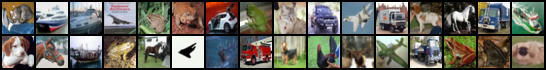

In [121]:
from torch.utils.data import DataLoader

tensor_dataloader = DataLoader(dataset=cifar10_dataset, batch_size=32)
data_iter = iter(tensor_dataloader)
img_tensor, label_tensor = next(data_iter)

print(img_tensor.shape)

# 将一个 batch 的图像数据拼接成一张大图进行展示
grid_tensor = torchvision.utils.make_grid(img_tensor, nrow=16, padding=2)
grid_img = transforms.ToPILImage()(grid_tensor)
display(grid_img)

In [122]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

可以看到，最后全连接层输入是 4096 个单元，输出是 1000 个单元，我们要把它修改为输出是 10 个单元的全连接层（CIFR10 有 10 类）。代码如下

In [123]:
# 提取分类层的输入参数
fc_in_features = alexnet.classifier[6].in_features # 修改预训练模型的输出分类数
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10).to(device)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [124]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             transform=transform,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transform,
                                            download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

# dataloader = DataLoader(dataset=cifar10_dataset, # 传入的数据集, 必须参数
#                                batch_size=32,       # 输出的batch大小
#                                shuffle=True,       # 数据是否打乱
#                                num_workers=2)      # 进程数, 0表示只有主进程

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)

# 训练模型 40 个 epoch
num_epochs = 5
alexnet.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = alexnet(inputs)
        loss = criterion(outputs, targets)

        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 在测试集上评估模型
alexnet.eval()  # 切换到评估模式（禁用dropout/bn更新）
correct = 0
total = 0
with torch.no_grad():  # 测试时不需要计算梯度
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)  # 取最大值对应的类别
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"✅ 测试准确率: {accuracy:.2f}%")

Epoch [1/5], Loss: 1.1755
Epoch [2/5], Loss: 0.9382
Epoch [3/5], Loss: 0.8813
Epoch [4/5], Loss: 0.8359
Epoch [5/5], Loss: 0.8179
✅ 测试准确率: 73.20%


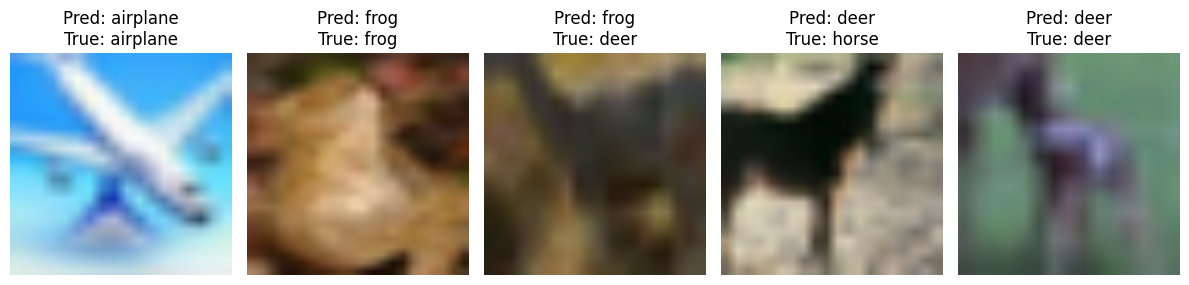

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import random

# CIFAR-10 类别名
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 随机抽查 3 个样本
samples = 5
alexnet.eval()
with torch.no_grad():
    # 从 test_dataset 随机取3张图
    indices = random.sample(range(len(test_dataset)), samples)
    fig, axs = plt.subplots(1, samples, figsize=(12, 4))

    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)  # 加上 batch 维度
        output = alexnet(input_tensor)
        _, pred = torch.max(output, 1)

        # 反归一化：从标准化后的张量恢复到原图
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(f"Pred: {classes[pred.item()]}\nTrue: {classes[label]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


对于一个网络还有很多其余层，比如 Dropout、Pooling 层、BN 层、激活函数等。Dropout 函数、Pooling 层、激活函数相对比较好理解，BN 层可能稍微复杂一些

打印 AlexNet 网络结构中的时候，它的一部分是使用 nn.Sequential 构建的。nn.Sequential 是一种快速构建网络的方式，

Epoch [1/16], Loss: 2.6193
Epoch [2/16], Loss: 1.0232
Epoch [3/16], Loss: 0.6723
Epoch [4/16], Loss: 0.4988
Epoch [5/16], Loss: 0.3959


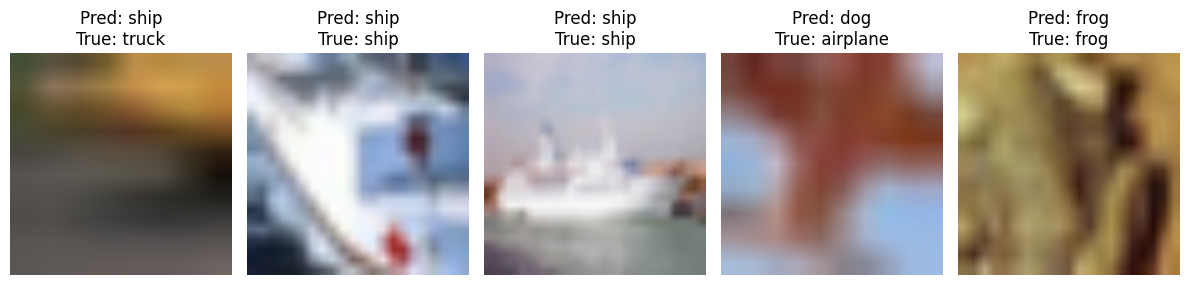

In [127]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        # conv1输出的特征图为222x222大小
        self.fc = nn.Linear(16 * 222 * 222, 10)

    def forward(self, input):
        x = self.conv1(input)
        # 进去全连接层之前，先将特征图铺平
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = MyCNN().to(device)

transform = transforms.Compose([
    # 修改裁剪图片的尺寸
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cifar10_dataset = torchvision.datasets.CIFAR10(root='./data',
                                               train=False,
                                               transform=transform,
                                               target_transform=None,
                                               download=True)

dataloader = DataLoader(dataset=cifar10_dataset,  # 传入的数据集, 必须参数
                        batch_size=32,  # 输出的batch大小
                        shuffle=True,  # 数据是否打乱
                        num_workers=2)  # 进程数, 0表示只有主进程

optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)
steps = 0

for epoch in range(5):
    running_loss = 0.0
    for item in dataloader:
        steps += 1
        outputs = cnn(item[0].to(device))
        targets = item[1].to(device)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        cnn.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/16], Loss: {running_loss/steps:.4f}")


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 随机抽查 3 个样本
samples = 5
alexnet.eval()
with torch.no_grad():
    # 从 test_dataset 随机取3张图
    indices = random.sample(range(len(test_dataset)), samples)
    fig, axs = plt.subplots(1, samples, figsize=(12, 4))

    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)  # 加上 batch 维度
        output = alexnet(input_tensor)
        _, pred = torch.max(output, 1)

        # 反归一化：从标准化后的张量恢复到原图
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(f"Pred: {classes[pred.item()]}\nTrue: {classes[label]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    


In [133]:

im = Image.open('test2.png')
input_tensor = transform(im).unsqueeze(0)
result = cnn(input_tensor.to(device)).argmax()
print(result)
print(f'预测类别: {classes[result.item()]}, 实际为: dog')

tensor(5, device='cuda:0')
预测类别: dog, 实际为: dog
